### <center>Use of B-splines in the spline collocation method

In [1]:
import numpy as np
import sympy as sp
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def true_func(x_values):
    x = sp.symbols('x')
    expr = 1 / (x + 1)
    func = sp.lambdify(x, expr, "numpy")
    return func(x_values)


def p_func(x_values):
    x = sp.symbols('x')
    expr = -(x + 1)**2
    func = sp.lambdify(x, expr, "numpy")
    return func(x_values)
    

def f_func(x_values):
    return np.ones(len(x_values))
    

def q_func(x_values):
    x = sp.symbols('x')
    expr = -2 / (x + 1)**2
    func = sp.lambdify(x, expr, "numpy")
    return func(x_values)


def A_(k):
    if k == -1: return alpha1 * h[3] - 3 * beta1
    elif k == n: return alpha2 * h[n + 1] - 3 * beta2
    else: return (1 - p[k + 3] * h[k + 3] / 2 + q[k + 3] * h[k + 3]**2 / 6) / (nodes[k + 4] - nodes[k + 1])


def D_(k):
    if k == -1: return alpha1 * h[3] + 3 * beta1
    elif k == n: return alpha2 * h[n + 1] + 3 * beta2
    else: return (1 + p[k + 3] * h[k + 2] / 2 + q[k + 3] * h[k + 2]**2 / 6) / (nodes[k + 5] - nodes[k + 2])


def C_(k):
    if k == -1: return 2 * alpha1 * (h[3] + h[4])
    elif k == n: return 2 * alpha2 * (h[n] + h[n + 3])
    else: return -A_(k) - D_(k) + q[k + 3] * (h[k + 3] + h[k + 2]) / 6


def F_(k):
    if k == -1: return 2 * gamma1 * (2 * h[3] + h[4])
    elif k == n: return 2 * gamma2 * (2 * h[n + 1] + h[n])
    else: return f[k + 3] * (h[k + 3] + h[k + 2]) / 6


def A_tilda(k):
    if k == n - 1: return A_(n - 1) - A_(n) * D_(n - 1) / D_(n)


def D_tilda(k):
    if k == 0: return D_(0) - D_(-1) * A_(0) / A_(-1)


def C_tilda(k):
    if k == 0: return C_(0) - C_(-1) * A_(0) / A_(-1)
    if k == n - 1: return C_(n - 1) - C_(n) * D_(n - 1) / D_(n)


def F_tilda(k):
    if k == 0: return F_(0) - F_(-1) * A_(0) / A_(-1)
    if k == n - 1: return F_(n - 1) - F_(n) * D_(n - 1) / D_(n)


def B_spline_collocation(A, b):
    A[0, 0] = C_tilda(0)
    A[0, 1] = D_tilda(0)
    b[0] = F_tilda(0)

    A[n - 1, n - 2] = A_tilda(n - 1)
    A[n - 1, n - 1] = C_tilda(n - 1)
    b[n - 1] = F_tilda(n - 1)

    for k in range(1, n - 1):
        A[k, k - 1] = A_(k)
        A[k, k] = C_(k)
        A[k, k + 1] = D_(k)
        b[k] = F_(k)
    return A, b


def tridiagona_matrix_algorithm(A, b):
    n = A.shape[0]
    c = np.zeros(n-1) # subdiagonal elements
    d = np.zeros(n) # main diagonal
    e = np.zeros_like(c) # supradiagonal elements
    
    for i in range(n - 1):
        c[i] = A[i+1, i]
        d[i] = A[i, i]
        e[i] = A[i, i+1]
    d[n-1] = A[n-1, n-1]
    
    alpha = np.zeros(n-1)
    beta = np.zeros_like(alpha)
    
    # Straight direction
    alpha[0] = -e[0] / d[0]
    beta[0] = b[0] / d[0]
    
    for i in range(1, n - 1):
        alpha[i] = -e[i] / (c[i - 1] * alpha[i - 1] + d[i])
        beta[i] = (b[i] - c[i - 1] * beta[i - 1]) / (c[i - 1] * alpha[i - 1] + d[i])
    
    # Reverse direction
    x = np.zeros_like(b)
    x[n - 1] = (b[n - 1] - c[n - 2] * beta[n - 2]) / (c[n - 2] * alpha[n - 2] + d[n - 1])
    
    for i in range(n - 2, -1, -1):
        x[i] = alpha[i] * x[i + 1] + beta[i]

    return x

In [3]:
n = 10000
left, right = 0, 1
alpha1, alpha2 = 1, 1
beta1, beta2 = -1, 0
gamma1, gamma2 = 2, 0.5

In [4]:
nodes = np.linspace(left, right, n)
h = np.diff(nodes)
for j in range(1, 4):
    h = np.insert(h, 0, h[0])
    nodes = np.insert(nodes, 0, nodes[0] - h[0])
    h = np.insert(h, len(h), h[-1])
    nodes = np.insert(nodes, len(nodes), nodes[-1] + h[-1])

In [5]:
p = p_func(nodes)
q = q_func(nodes)
f = f_func(nodes)
A = np.zeros((n, n))
b = np.zeros(n)

In [6]:
A, b = B_spline_collocation(A, b)

In [7]:
true_values = true_func(nodes)
result_values = tridiagona_matrix_algorithm(A, b)

result_values

array([0.99999999, 0.99989999, 0.99980001, ..., 0.50005001, 0.500025  ,
       0.5       ])

In [8]:
nodes_error_1 = np.abs(result_values - true_values[3: -3])

print(f"Max_error1: {np.max(nodes_error_1)}")

Max_error1: 5.0456482325600405e-09


In [9]:
res_bound_left = (F_(-1) - result_values[0] * C_(-1) - result_values[1] * D_(-1)) / A_(-1)
res_bound_right = (F_(n) - result_values[n - 2] * A_(n) - result_values[n - 1] * C_(n)) / A_(n)

In [10]:
fr = np.zeros_like(result_values) # fr <- final_result
fr[0] = res_bound_left / 6 + 2 * result_values[0] / 3 + result_values[1] / 6
fr[-1] = result_values[-2] / 6 + 2 * result_values[-1] / 3 + res_bound_right / 6
for i in range(1, n - 1):
    fr[i] = result_values[i - 1] / 6 + 2 * result_values[i] / 3 + result_values[i + 1] / 6

fr

array([1.        , 0.9999    , 0.99980002, ..., 0.50005001, 0.500025  ,
       0.5       ])

In [11]:
nodes_error_2 = np.abs(fr - true_values[3: -3])
print(f"Max_error2: {np.max(nodes_error_2)}")

Max_error2: 1.8360295506170132e-09


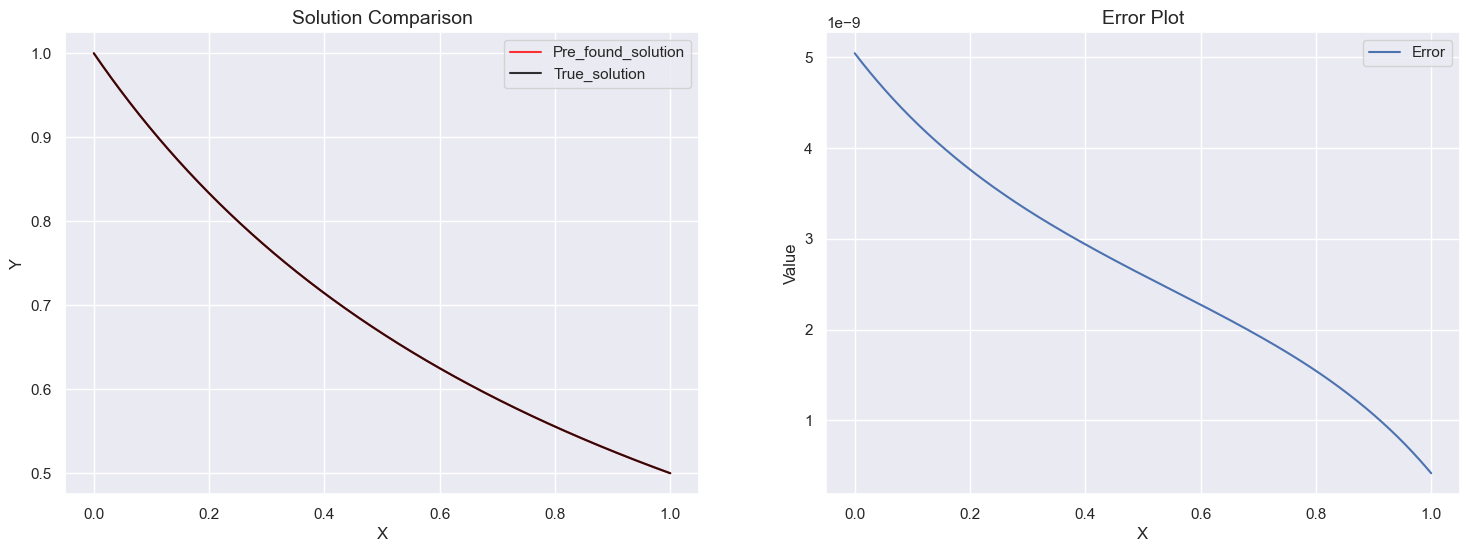

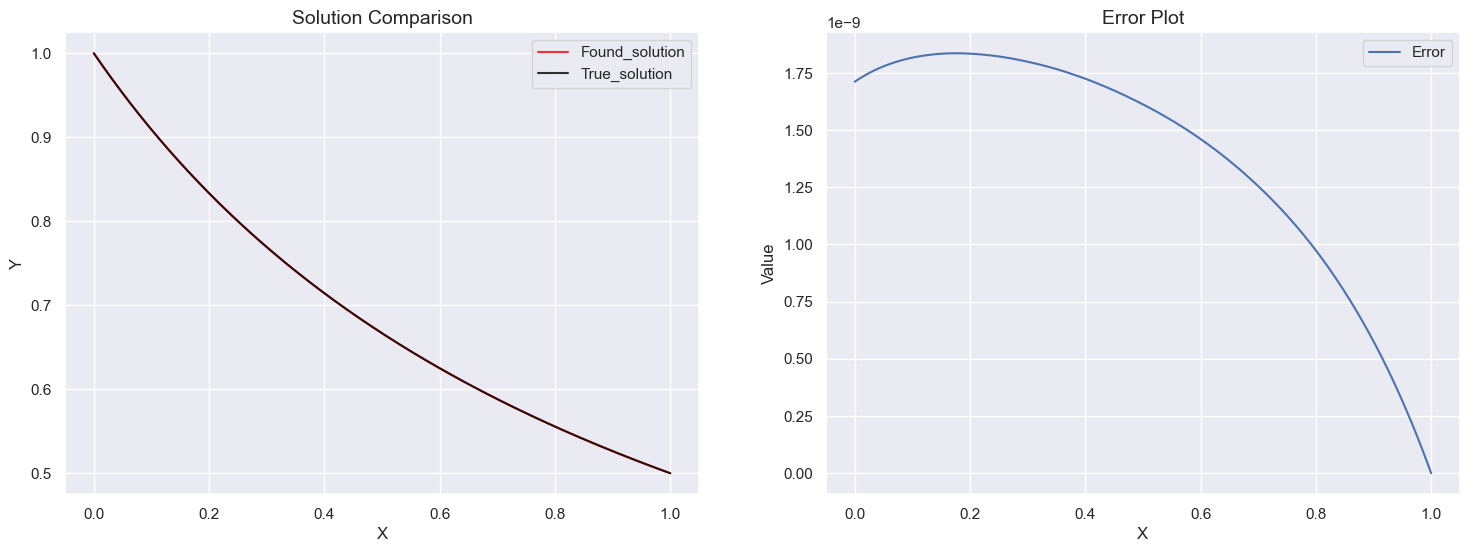

In [12]:
sns.set()

fig, axs = plt.subplots(1, 2, figsize=(18, 6))
sns.lineplot(ax=axs[0], y=result_values, x=nodes[3:-3], label="Pre_found_solution", alpha=0.8, c="red")
sns.lineplot(ax=axs[0], y=true_values[3:-3], x=nodes[3:-3], label="True_solution", alpha=0.8, c="black")
axs[0].set_xlabel("X", fontsize=12)
axs[0].set_ylabel("Y", fontsize=12)
axs[0].set_title("Solution Comparison", fontsize=14)
axs[0].legend()

sns.lineplot(ax=axs[1], y=nodes_error_1, x=nodes[3:-3], label="Error")
axs[1].set_xlabel("X", fontsize=12)
axs[1].set_ylabel("Value", fontsize=12)
axs[1].set_title("Error Plot", fontsize=14)
axs[1].grid(True)

plt.show()


fig, axs = plt.subplots(1, 2, figsize=(18, 6))
sns.lineplot(ax=axs[0], y=fr, x=nodes[3:-3], label="Found_solution", alpha=0.8, c="red")
sns.lineplot(ax=axs[0], y=true_values[3:-3], x=nodes[3:-3], label="True_solution", alpha=0.8, c="black")
axs[0].set_xlabel("X", fontsize=12)
axs[0].set_ylabel("Y", fontsize=12)
axs[0].set_title("Solution Comparison", fontsize=14)
axs[0].legend()

sns.lineplot(ax=axs[1], y=nodes_error_2, x=nodes[3:-3], label="Error")
axs[1].set_xlabel("X", fontsize=12)
axs[1].set_ylabel("Value", fontsize=12)
axs[1].set_title("Error Plot", fontsize=14)
axs[1].grid(True)

plt.show()